# Validation Paper: CCDF Measurements/Plots

In [1]:
%reload_ext autoreload
from utils.parsePcap import TsnParsePcap
from utils.createPlot import TsnCreatePlot
from utils.util import *
from pandas import read_csv, concat, cut

In [2]:
CONFIGURATION = {"Kontron": {
                    "no_cts": "KONTRON_1ms-60s-NULL-NULL_txinject-TAS-no-CTS_1518_200.0percent.pcap",
                    "cts": "KONTRON_1ms-60s-NULL-NULL_txinject-TAS-CTS_1518_200.0percent.pcap"
                    },
                 "FibroLAN": {
                    "no_cts": "FibroLAN_1ms-60s-NULL-NULL_txinject-TAS-no-CTS_1518_200.0percent.pcap",
                    "cts": "FibroLAN_1ms-60s-NULL-NULL_txinject-TAS-CTS_1518_200.0percent.pcap"
                    }
                 }

SOURCE_PATH_ROOT = "/mnt/harddrive/data/pcaps"
OUTPUT_PATH_ROOT = "/home/arch/validation_paper"
mapping = {1: "robotic"}

FRAME LOSS DETECTED IN robotic STREAM!
FRAME INDEX FROM PCAP: 10581
EXPECTED INDEX IN DATAFRAME: 10580
FRAME LOSS DETECTED IN robotic STREAM!
FRAME INDEX FROM PCAP: 10581
EXPECTED INDEX IN DATAFRAME: 10580


TypeError: '>' not supported between instances of 'NoneType' and 'int'

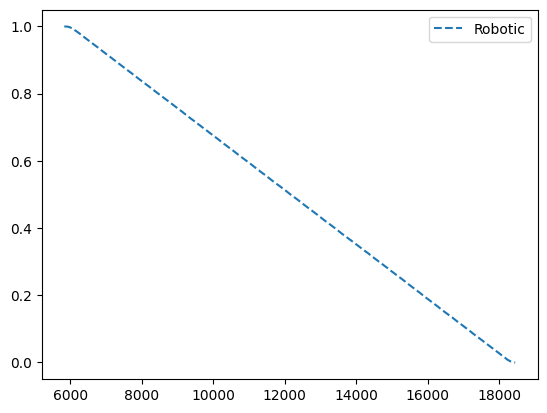

In [3]:
dfs = []

for vendor, config in CONFIGURATION.items():
    for qos, pcap in config.items():
        input_path = "{}/{}".format(SOURCE_PATH_ROOT, pcap)
        output_path = "{}/{}".format(OUTPUT_PATH_ROOT, vendor)

        pp = TsnParsePcap(path=input_path,
                          mapping=mapping,
                          output_path=output_path)
        pp.pcap_to_dfs()
        d = pp.get_dfs()
        dfs.append(d)

        cp = TsnCreatePlot(dfs=d,
                           output_path=output_path,
                           mapping=mapping,
                           bg_load=None,
                           bg_framesize=None,
                           qos_type="None")
        cp.generate_plots(plot_type="latency_ccdf", output="csv")
        cp.generate_plots(plot_type="latency_ccdf", output="mpl")

In [ ]:
latencies = {}

for c, files in paths.items():
    for file in files:
        name = get_filename(file)
        print("{}-{}".format(c, name))
        output_path = "{}/{}-{}".format(OUTPUT_PATH_ROOT, c, name)

        pp.pcap_to_dfs()
        dfs = pp.get_dfs()
        cp = TsnCreatePlot(dfs=dfs,
                           output_path=output_path,
                           mapping=mapping,
                           bg_load=None,
                           bg_framesize=None,
                           qos_type="None")
        cp.generate_plots(plot_type="latency_ccdf", output="csv")
        cname = "{}-{}".format(c, name)
        latencies[cname] = None

## Generate Data for PGF:

In [31]:
csvs = {}

for name, file in files.items():
    for c in ["CT", "NO_CT"]:
        cname = "{}-{}".format(c, name)
        csv_path = "{}/{}/csv/latency_ccdf_robotic.csv".format(OUTPUT_PATH_ROOT, cname)
        csvs[cname] = read_csv(csv_path)

csvs_new = []
for name, df in csvs.items():
    df = df[["Latency (ns)", "ccdf"]]
    df.rename(columns={"Latency (ns)": "x-{}".format(name),
                       "ccdf": "y-{}".format(name)},
              errors="raise",
              inplace=True)
    csvs_new.append(df)

del csvs
del df

df_pgf = concat(csvs_new,
                axis=1,
                join="outer",
                ignore_index=False)

df_pgf.to_csv("{}/ccdf.csv".format(OUTPUT_PATH_ROOT),
              index=False,
              header=True,
              sep="\t")

## Sample Data:

In [ ]:
group = "extension_pdv"

PATH = "/home/arch/validation_paper/{}".format(group)

files = []
for f in sorted(listdir(PATH)):
    if f.endswith(".csv"):
        files.append("{}/{}".format(PATH, f))

In [ ]:
for file in files:
    filename = file.split(group + "/")[-1].strip(".csv")

    df = read_csv(file, sep="\t")

    dfs = []

    for i in range(0, 3):
        xname = "x{}".format(i)
        yname = "y{}".format(i)

        columns = [xname, yname]

        filtered = df[columns].dropna()

        bins = [-1e-1, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

        filtered["bins"] = cut(filtered[yname], bins=bins)
        f = filtered.groupby('bins', group_keys=False).apply(lambda x: x.sample(min(len(x), 100))).sort_values(yname, ascending=False).reset_index(drop=True)
        if f.iloc[-1, f.columns.get_loc(yname)] == 0:
            f.iloc[-1, f.columns.get_loc(yname)] = 1e-6
        dfs.append(f[[xname, yname]])

    out = concat(dfs, axis=1)
    out.to_csv("{}/sampled/{}_sampled.csv".format(PATH, filename), index=False, header=True, sep="\t")
    del out
    del dfs